In [1]:
# encoding=utf8
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os
from bs4 import BeautifulSoup

from keras.preprocessing.text import Tokenizer,one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model
from keras.layers.merge import Concatenate
from keras import optimizers

os.environ['KERAS_BACKEND']='tensorflow'

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
TRAINING_SPLIT = 0.6
VALIDATION_SPLIT = 0.2
epochs = 10
batch_size = 128
np.random.seed(7)

Using TensorFlow backend.


In [2]:
def clean_str(string):
    string = re.sub("[\s+\.\!,\"\']+".decode("utf8"), "", string)   
    string = re.sub("[！，。？、~（）]+".decode("utf8"), "", string)  
    string = re.sub("[【】『』「」︰：]+".decode("utf8"), "", string) 
    string = re.sub("[《》”“；]+".decode("utf8"),"",string)
    return string.strip()

def one_hot_encoding(labels):
    one_hot_labels = []
    for label in labels:
        if label.decode("utf8") == u"足球":
            one_hot_labels.append([0.,0.,1.])
        if label.decode("utf8") == u"梁振英":
            one_hot_labels.append([0.,1.,0.])
        if label.decode("utf8") == u"美國大選":
            one_hot_labels.append([1.,0.,0.])
    return one_hot_labels

In [3]:
train_path = "./dataset/train_set.csv"
test_path = "./dataset/test_set.csv"
data_train = pd.read_csv(train_path)
data_test = pd.read_csv(test_path)
print ("training data: ", data_train.shape)
print ("testing data: ", data_test.shape)

('training data: ', (3894, 3))
('testing data: ', (974, 2))


In [4]:
texts = []
labels = []
for idx in xrange(data_train.content.shape[0]):
    soup = BeautifulSoup(data_train.content[idx],"lxml")
    text = soup.get_text()
    texts.append(clean_str(text).encode("utf8"))
    labels.append(data_train.label[idx])

In [5]:
test_texts = []
for idx in xrange(data_test.content.shape[0]):
    soup = BeautifulSoup(data_test.content[idx],"lxml")
    text = soup.get_text()
    test_texts.append(clean_str(text).encode("utf8"))

In [6]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts+test_texts)
sequences = tokenizer.texts_to_sequences(texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

In [7]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 24455 unique tokens.


In [8]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(one_hot_encoding(labels)).reshape(-1,3)

print('Shape of training tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

('Shape of training tensor:', (3894, 1000))
('Shape of label tensor:', (3894, 3))


In [9]:
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of testing tensor:', test_data.shape)

('Shape of testing tensor:', (974, 1000))


In [10]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [11]:
train_index = int(TRAINING_SPLIT*data.shape[0])
validation_index = train_index + int(VALIDATION_SPLIT*data.shape[0])

x_train = data[:train_index]
y_train = labels[:train_index]
x_val = data[train_index:validation_index]
y_val = labels[train_index:validation_index]
x_test = data[validation_index:]
y_test = labels[validation_index:]

In [12]:
print ("train: ", x_train.shape, y_train.shape)
print ("validation: ", x_val.shape, y_val.shape)
print ("test: ",x_test.shape, y_test.shape)

('train: ', (2336, 1000), (2336, 3))
('validation: ', (778, 1000), (778, 3))
('test: ', (780, 1000), (780, 3))


The text CNN model doesn't get a good job because I use the pretrained glove dictionary provided by Standford NLP, there is just few chinese characters in that dictionary, I should train the self dictionary to get competitive result  

In [13]:
GLOVE_DIR = "./glove.6B"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

Total 400000 word vectors in Glove 6B 100d.


In [14]:
from keras.callbacks import ModelCheckpoint

convs = []
kernel_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for ksz in kernel_sizes:
    l_conv = Conv1D(filters=128,kernel_size=ksz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)
    
merge = Concatenate(axis=1)(convs)
cov1= Conv1D(128, 5, activation='relu')(merge)
pool1 = MaxPooling1D(5)(cov1)
cov2 = Conv1D(128, 5, activation='relu')(pool1)
pool2 = MaxPooling1D(30)(cov2)
flat_layer = Flatten()(pool2)
dense_layer = Dense(128, activation='relu')(flat_layer)
dropout_layer = Dropout(0.5)(dense_layer)
preds_layer = Dense(3, activation='softmax')(dropout_layer)

model = Model(sequence_input, preds_layer)
rmsprop = optimizers.RMSprop(lr=0.001,decay=1e-5)

#model.load_weights("./best_weights.hdf5")
model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop,
              metrics=['acc'])

print("model fitting")
model.summary()
checkpointer = ModelCheckpoint(filepath='./best_weights.hdf5', verbose=1, save_best_only=True)
callbacks_list = [checkpointer]
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=20, batch_size=batch_size, callbacks=callbacks_list)

model fitting
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1000)          0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 1000, 100)     2445600     input_1[0][0]                    
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 998, 128)      38528       embedding_1[0][0]                
____________________________________________________________________________________________________
conv1d_2 (Conv1D)                (None, 997, 128)      51328       embedding_1[0][0]                
_____________________________________________________________________________

In [19]:
model.load_weights("./model_weight/tc1.h5")

In [20]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 70.64%


In [16]:
print("Saved model to disk")
model_json = model.to_json()
with open("tc1.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("tc1.h5", overwrite=True)

Saved model to disk


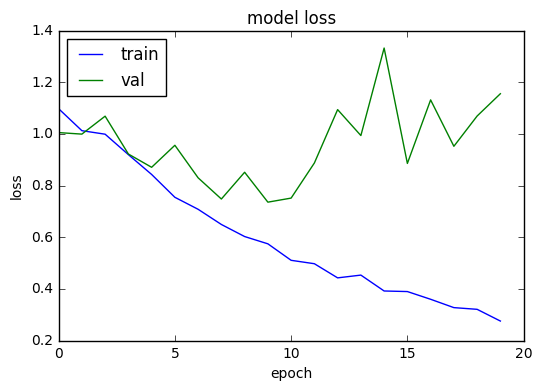

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
y_pred = model.predict(test_data)
y_pred = np.round(y_pred)

In [23]:
test_label = []
for i in range(len(y_pred)):
    if y_pred[i].tolist() == [0,0,1]:
        test_label.append(u"足球")
    if y_pred[i].tolist() == [0,1,0]:
        test_label.append(u"梁振英")
    if y_pred[i].tolist() == [1,0,0]:
        test_label.append(u"美國大選")
    if y_pred[i].tolist() == [0,0,0]:
        test_label.append(u"其他")

In [24]:
data_test["label"] = test_label

In [25]:
print data_test

        id                                            content label
0        6  南華添鋒力　簽前厄瓜多爾國腳保耶 港超勁旅南華宣布羅致前厄瓜多爾國腳菲力斯保耶（Felix ...    足球
1      128  如果大學$0捐款　科大嶺南將蝕過千萬元 據now新聞台報道，身兼8大校監的特首梁振英曾以大學...    足球
2      136  英超最強火力對碰　雙城爭冠靠鋒霸 英超今季風起雲湧，傳統「Big 5」只剩兩隊名列積分榜前5...    足球
3      213  【01球評】膺半程冠軍　阿仙奴今季不奪標更待何時？ 近年「兵工廠」每季的起落都離不開一個循環...    足球
4      658  【書商失蹤】梁振英：希望失蹤的李波本人提供資料 行政長官梁振英出席行政會議前見記者，被問及李...   梁振英
5      700  【施政盤點】三份施政報告　僅一半政策達標 行政長官梁振英即將公布任內第四份施政報告，《香港0...    足球
6      729  【施政盤點】「治港絕招」　設19委員會　空談多實務少 行政長官梁振英上任3年多，先後成立多個...    足球
7      837  高普首簽　「新馬迪」來季投紅軍 利物浦傷兵滿營及戰績不穩，主帥高普仍不忘投資未來，昨以510...    足球
8     1037  「最潮主帥」鬥利物浦：我已領先1：0 英乙球隊埃克塞特在明晨的足總盃於主場迎戰利物浦，雖然越...    足球
9     1095  紅軍超殘陣逼和英乙隊　高普：負擔不起重賽 逾十名球員受傷的利物浦，今晨在足總盃第三圈以大部份...    足球
10    1113  【施丹上馬】皇馬六條A　退下來各自精彩　僅卡路士教波 2003年碧咸轉投皇家馬德里，與施丹、...   梁振英
11    1153  【施丹上馬】踢而優則教　碧根鮑華告魯夫完美球王 足球史上，獲譽為球王的寥寥可數，踢而優則教的...   梁振英
12    1200  【01球評】施丹首戰　回歸原點抄足肥安　防守毛病未解決 所謂「新官上任三把火」，不過從皇家馬...    足球
13    1261  新兵白鶴對辦　東方大破南華踞榜首現霸氣 星期日下午的港超榜首大戰，東方在

In [26]:
data_test.to_csv("./prediction.csv", encoding='utf-8')